In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import lit
from pyspark.sql.functions import col, date_format, month, count, avg, max, min, to_date, to_timestamp, sum, when, dayofweek, hour, year, when

In [2]:
spark = SparkSession.builder.appName('App')\
        .config("spark.executor.cores",'16')\
        .config("spark.executor.memory", '60g')\
        .getOrCreate()

### Read Data

In [3]:
df2021 = spark.read.option("header", "true").option("inferSchema", "true").csv("gs://project_hyrn/2021_Yellow_Taxi_Trip_Data_full.csv")

In [4]:
df2020 =spark.read.option("header", "true").option("inferSchema", "true").csv("gs://project_hynr2/2020_Yellow_Taxi_Trip_Data_full.csv")

In [5]:
df2019 =spark.read.option("header", "true").option("inferSchema", "true").csv("gs://project_hynr2/2019_Yellow_Taxi_Trip_Data_full.csv")

In [6]:
sampled_2021 = df2021.sample(fraction=0.001, seed=12)
sampled_2020 = df2020.sample(fraction=0.001, seed=34)
sampled_2019 = df2019.sample(fraction=0.001, seed=56)

In [7]:
sampled_2021 = sampled_2021.withColumn("Datayear", lit(2021))
sampled_2020 = sampled_2020.withColumn("Datayear", lit(2020))
sampled_2019 = sampled_2019.withColumn("Datayear", lit(2019))

In [8]:
print(sampled_2021 .count(),len(sampled_2021 .columns))

31103 19


In [9]:
sampled_2021.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Datayear: integer (nullable = false)



In [10]:
sampled_2021.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+--------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Datayear|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+--------+
|       2|01/01/2021 01:45:...| 01/01/2021 02:00:...|              1|         4.62|         1|                 N|          50|          74|           2|       15.5|  0.5|    0.5|       0.0|       

In [11]:
union_df = sampled_2021.union(sampled_2020).union(sampled_2019)

### Check Number of Partitions - Equally partitioned

In [12]:
#display number of records by partition
def displaypartitions(df):
    #number of records by partition
    num = df.rdd.getNumPartitions()
    print("Partitions:", num)
    df.withColumn("partitionId", F.spark_partition_id())\
        .groupBy("partitionId")\
        .count()\
        .orderBy(F.asc("count"))\
        .show(num)

In [13]:
#number of partitions
union_df.rdd.getNumPartitions()

103

In [ ]:
#re-partition the data to evenly distributed across 8 partitions
union_df = union_df.repartition(8)
displaypartitions(union_df)

### Feature Engineering

In [14]:
# change to date type
union_df = union_df.withColumn("parsed_pickup_datetime", to_timestamp("tpep_pickup_datetime", "MM/dd/yyyy hh:mm:ss a"))
union_df = union_df.withColumn("parsed_dropoff_datetime", to_timestamp("tpep_dropoff_datetime", "MM/dd/yyyy hh:mm:ss a"))
union_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Datayear: integer (nullable = false)
 |-- parsed_pickup_datetime: timestamp (nullable = true)
 |-- parsed_dropoff_datetime: timestamp (nullable = true)



In [15]:
# calcualte average spent per mile and avergae spent per min
union_df = union_df.withColumn("PerMile", col("total_amount") / col("trip_distance"))

#df2021Full = df2021Full.withColumn("Dur",  col("parsed_dropoff_datetime") - col("parsed_pickup_datetime"))
from pyspark.sql.functions import datediff, minute, hour
union_df = union_df.withColumn("Dur", datediff("parsed_dropoff_datetime", "parsed_pickup_datetime") * 24 * 60 +hour("parsed_dropoff_datetime")* 60-hour("parsed_pickup_datetime")*60
+ minute("parsed_dropoff_datetime") - minute("parsed_pickup_datetime"))

union_df = union_df.withColumn("PerMin", col("total_amount") / col("Dur"))

In [16]:
union_df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+--------+----------------------+-----------------------+-------------------+---+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Datayear|parsed_pickup_datetime|parsed_dropoff_datetime|            PerMile|Dur|            PerMin|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+--------+-----------------

In [17]:
Avg_Spent_vendor = union_df.groupBy("VendorID") \
                           .agg(avg("PerMile").alias("Avg spent per mile"),avg("PerMin").alias("Avg spent per min")) \
                           .orderBy(col("Avg spent per mile").desc()) 
                           
Avg_Spent_vendor.show()
# vendor 2 is the most expensive provider

+--------+------------------+------------------+
|VendorID|Avg spent per mile| Avg spent per min|
+--------+------------------+------------------+
|       2|  12.5911497186835|1.6423923531078637|
|    null|10.892044604974704| 1.697111199184537|
|       1| 10.08106047760557|1.6612353016642727|
|       4| 9.767846459965192|1.5615209390157707|
|       6|  9.62561063267502|0.6959078816332338|
+--------+------------------+------------------+



In [18]:
# Extract the hour from pickup time
union_df = union_df.withColumn("pickup_hour", hour("parsed_pickup_datetime"))

In [19]:
Avg_Spent_hour = union_df.groupBy("pickup_hour") \
                           .agg(avg("PerMile").alias("Avg spent per mile"),avg("PerMin").alias("Avg spent per min")) \
                           .orderBy(col("pickup_hour").desc()) 

In [20]:
Avg_Spent_hour.show()

+-----------+------------------+------------------+
|pickup_hour|Avg spent per mile| Avg spent per min|
+-----------+------------------+------------------+
|         23| 8.554530661884005| 1.723918538893682|
|         22|10.266984480003229| 1.726358779936844|
|         21|11.858325573219092|1.7732381007683053|
|         20|11.650004363052822|1.7369154314101667|
|         19|11.933559838864577|1.6674418586009043|
|         18|12.552341957998939| 1.644487295267189|
|         17|10.585370983255753| 1.600621894159323|
|         16|11.220975270350008|1.5852400705303638|
|         15|13.716814168920024| 1.481311728411835|
|         14|11.209143104854817|1.4932709228000574|
|         13| 15.38820012367774|1.5650985209000197|
|         12|12.063912820340075|1.5187761265515423|
|         11|10.152632417789953|  1.49262484004646|
|         10|12.419928806830928|1.5453010022923455|
|          9|11.933320023992628|1.6158995776612244|
|          8|12.924675913034514|1.6265279746782444|
|          7

In [21]:
Spent_hour_plot=Avg_Spent_hour.toPandas()

In [22]:
Spent_hour_plot

,pickup_hour,Avg spent per mile,Avg spent per min
0,23,8.554531,1.723919
1,22,10.266984,1.726359
2,21,11.858326,1.773238
3,20,11.650004,1.736915
4,19,11.933560,1.667442
5,18,12.552342,1.644487
6,17,10.585371,1.600622
7,16,11.220975,1.585240
8,15,13.716814,1.481312
9,14,11.209143,1.493271


<AxesSubplot:xlabel='pickup_hour'>

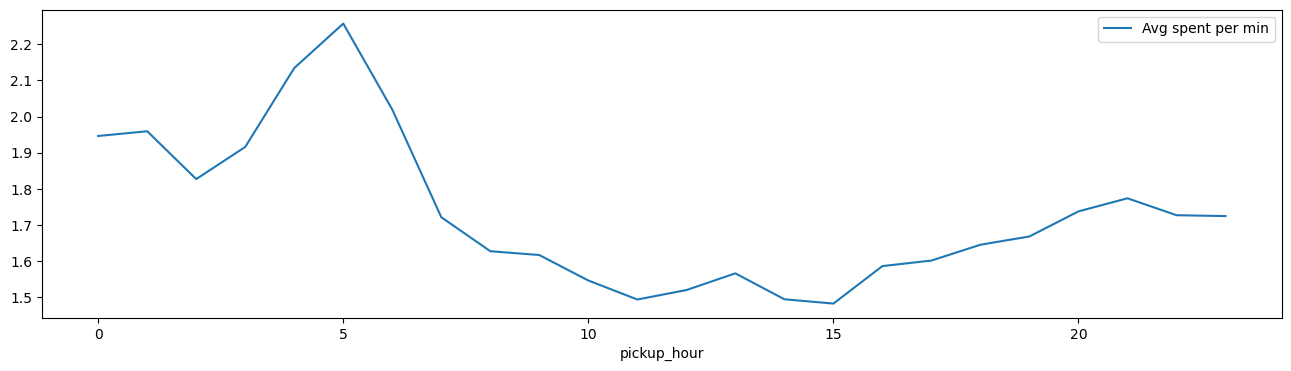

In [23]:
Spent_hour_plot.plot(y='Avg spent per min', x ='pickup_hour',figsize=(16,4))

<AxesSubplot:xlabel='pickup_hour'>

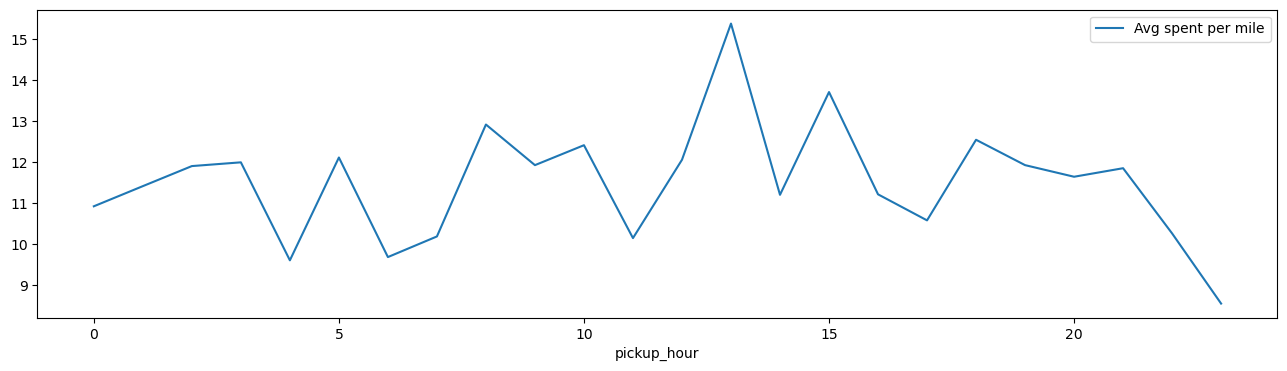

In [24]:
Spent_hour_plot.plot(y='Avg spent per mile',  x ='pickup_hour', figsize=(16,4))

<AxesSubplot:xlabel='pickup_hour'>

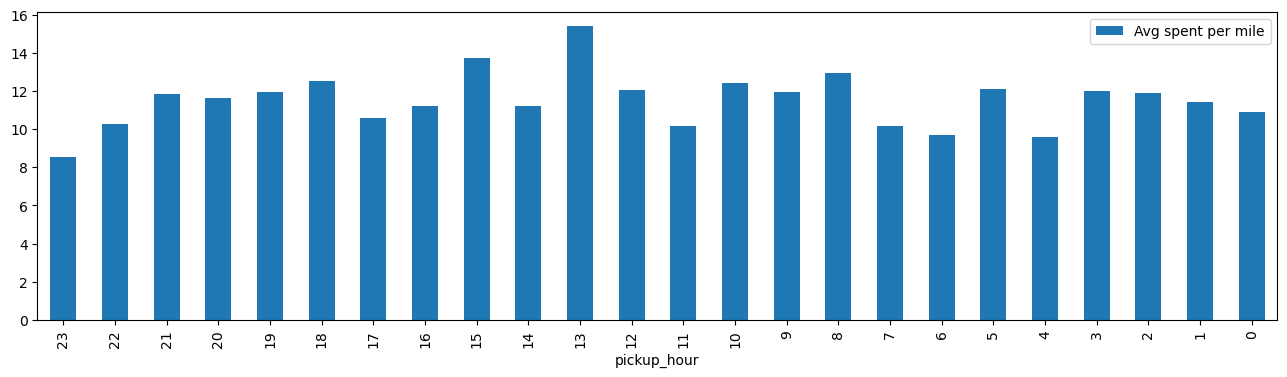

In [25]:
Spent_hour_plot.plot(y='Avg spent per mile',  x ='pickup_hour', kind='bar', figsize=(16,4))

## EDA by Freya

### Feature Engineering Cont.

In [26]:
# Extract the month and day of week from pickup time
union_df = union_df.withColumn("pickup_month", month("parsed_pickup_datetime"))
union_df = union_df.withColumn("pickup_dayofweek", dayofweek("parsed_pickup_datetime"))
union_df.printSchema()
union_df.show(10)

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Datayear: integer (nullable = false)
 |-- parsed_pickup_datetime: timestamp (nullable = true)
 |-- parsed_dropoff_datetime: timestamp (nullable = true)
 |-- PerMile: dou

23/05/12 13:42:47 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+--------+----------------------+-----------------------+-------------------+---+------------------+-----------+------------+----------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Datayear|parsed_pickup_datetime|parsed_dropoff_datetime|            PerMile|Dur|            PerMin|pickup_hour|pickup_month|pickup_dayofweek|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+-----------

In [27]:
# Create a dummy variable of weekday
union_df = union_df.withColumn("pickup_weekday", when((union_df["pickup_dayofweek"] >= 2) & (union_df["pickup_dayofweek"] <= 6), 1).otherwise(0))
union_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Datayear: integer (nullable = false)
 |-- parsed_pickup_datetime: timestamp (nullable = true)
 |-- parsed_dropoff_datetime: timestamp (nullable = true)
 |-- PerMile: dou

In [28]:
# Create a season variable
union_df = union_df.withColumn(
    "season",
    when((union_df.pickup_month <= 2) | (union_df.pickup_month == 12), 1)
    .when((union_df.pickup_month >= 3) & (union_df.pickup_month <= 5), 2)
    .when((union_df.pickup_month >= 6) & (union_df.pickup_month <= 8), 3)
    .otherwise(4),
)

In [29]:
# Data Type Transformation
# Convert store_and_fwd_flag to a dummy variable
union_df = union_df.withColumn("store_and_fwd_flag", 
                               when(union_df.store_and_fwd_flag == "Y", 1).otherwise(0))

In [30]:
union_df.printSchema()
union_df.show(10)

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: integer (nullable = false)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Datayear: integer (nullable = false)
 |-- parsed_pickup_datetime: timestamp (nullable = true)
 |-- parsed_dropoff_datetime: timestamp (nullable = true)
 |-- PerMile: d

### Data Cleaning ( cr.Helena )

In [31]:
# Filter for fare_amount >=3.0
union_df = union_df.filter(condition = col("fare_amount") >= 3.0)
# Filter out extreme points
union_df = union_df.filter((col("trip_distance") >= 0) & (col("trip_distance") < 200) & (col("fare_amount") < 400))

# Check date variables
union_df.describe('Datayear', 'pickup_month','pickup_dayofweek').show()

+-------+------------------+------------------+------------------+
|summary|          Datayear|      pickup_month|  pickup_dayofweek|
+-------+------------------+------------------+------------------+
|  count|            139253|            139253|            139253|
|   mean|2019.6201374476673| 6.258012394706038| 4.125548462151623|
| stddev|0.8235407817764109|3.6204710774447184|1.9398245499845297|
|    min|              2019|                 1|                 1|
|    max|              2021|                12|                 7|
+-------+------------------+------------------+------------------+



### Exploration by Year, Month, Weekday and Hour

#### 1. Average Fare Amount and Pickup Counts by Hour

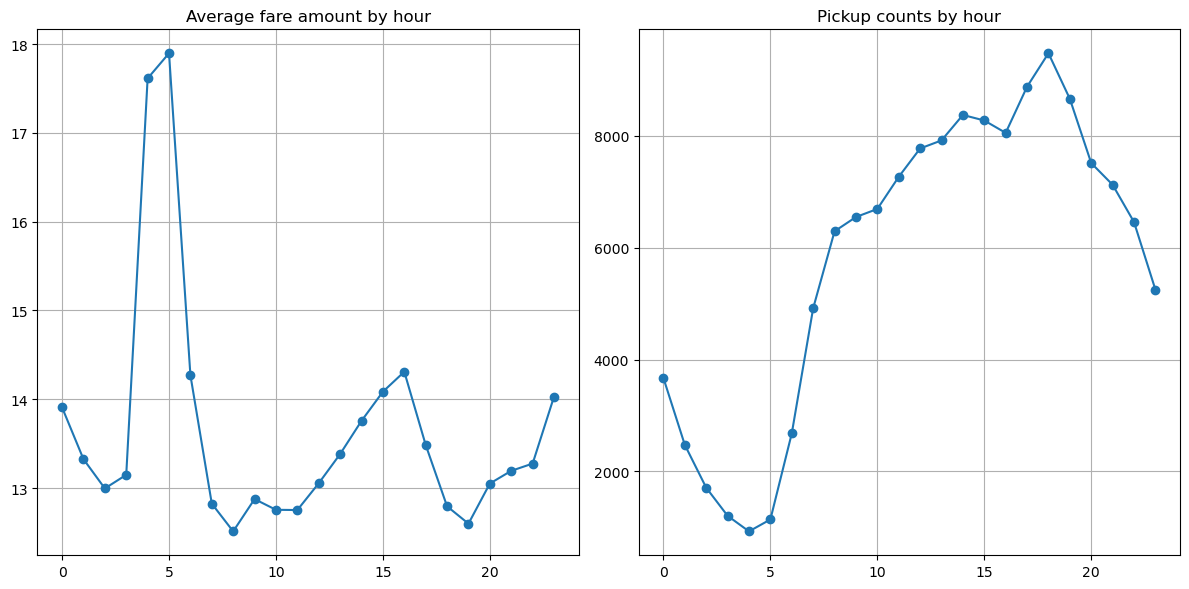

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by pickup_hour, calculate sums and counts
hourly_df = union_df.groupBy("pickup_hour")\
                     .agg(F.sum("fare_amount").alias("total_fare"),
                          F.count("*").alias("pickup_count"))

# Calculate averages
hourly_df = hourly_df.withColumn("avg_fare", F.col("total_fare") / F.col("pickup_count"))

# Convert to pandas DataFrame for plotting
hourly_pd = hourly_df.toPandas()

# Sort by pickup_hour for plotting
hourly_pd = hourly_pd.sort_values("pickup_hour")

# Create a new figure
plt.figure(figsize=(12, 6))

# Plot average fare amount by hour
plt.subplot(1, 2, 1)
plt.plot(hourly_pd["pickup_hour"], hourly_pd["avg_fare"], marker='o')
plt.title('Average fare amount by hour')
plt.grid(True)

# Plot pickup counts by hour
plt.subplot(1, 2, 2)
plt.plot(hourly_pd["pickup_hour"], hourly_pd["pickup_count"], marker='o')
plt.title('Pickup counts by hour')
plt.grid(True)

plt.tight_layout()
plt.show()

#### 2. By day of week: Average Fare Amount by Hour

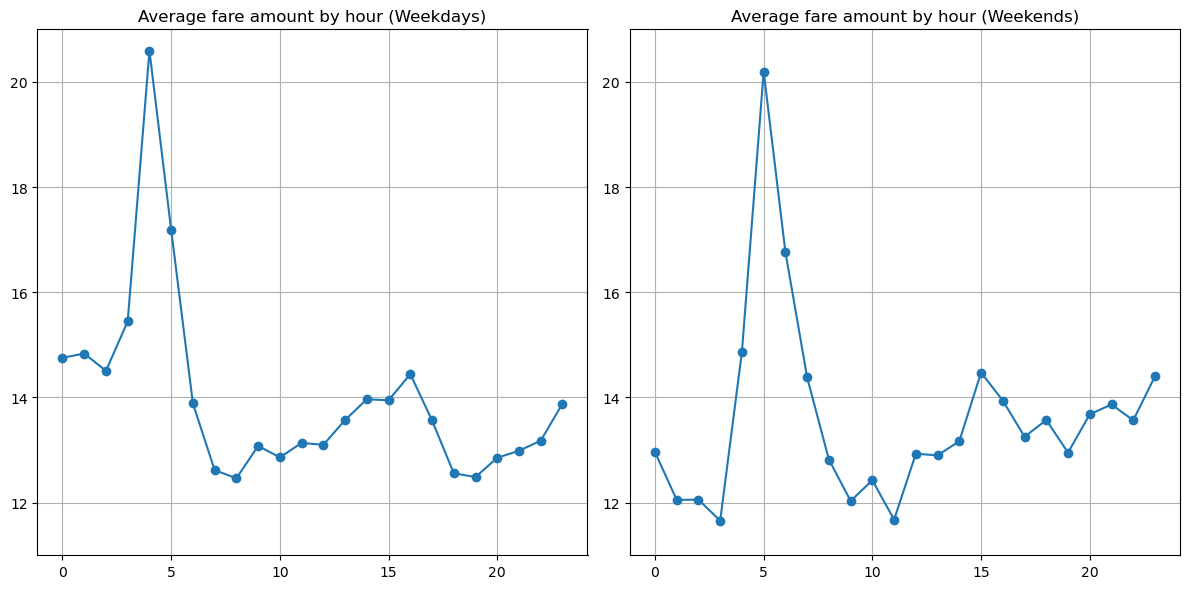

In [33]:
# Create two separate groups for weekdays and weekends
weekday_df = union_df.filter(F.col("pickup_weekday") == 1)
weekend_df = union_df.filter(F.col("pickup_weekday") == 0)

# Group by pickup_hour, calculate sums and counts for weekdays
weekday_hourly = weekday_df.groupBy("pickup_hour")\
                            .agg(F.sum("fare_amount").alias("total_fare"),
                                 F.count("*").alias("pickup_count"))
# Calculate averages for weekdays
weekday_hourly = weekday_hourly.withColumn("avg_fare", F.col("total_fare") / F.col("pickup_count"))

# Group by pickup_hour, calculate sums and counts for weekends
weekend_hourly = weekend_df.groupBy("pickup_hour")\
                            .agg(F.sum("fare_amount").alias("total_fare"),
                                 F.count("*").alias("pickup_count"))
# Calculate averages for weekends
weekend_hourly = weekend_hourly.withColumn("avg_fare", F.col("total_fare") / F.col("pickup_count"))

# Convert to pandas DataFrames for plotting
weekday_pd = weekday_hourly.toPandas()
weekend_pd = weekend_hourly.toPandas()

# Sort by pickup_hour for plotting
weekday_pd = weekday_pd.sort_values("pickup_hour")
weekend_pd = weekend_pd.sort_values("pickup_hour")

# Create a new figure
plt.figure(figsize=(12, 6))

# Plot average fare amount by hour for weekdays
plt.subplot(1, 2, 1)
plt.plot(weekday_pd["pickup_hour"], weekday_pd["avg_fare"], marker='o')
plt.title('Average fare amount by hour (Weekdays)')
plt.ylim(11, 21)
plt.grid(True)

# Plot average fare amount by hour for weekends
plt.subplot(1, 2, 2)
plt.plot(weekend_pd["pickup_hour"], weekend_pd["avg_fare"], marker='o')
plt.title('Average fare amount by hour (Weekends)')
plt.ylim(11, 21)
plt.grid(True)

plt.tight_layout()
plt.show()

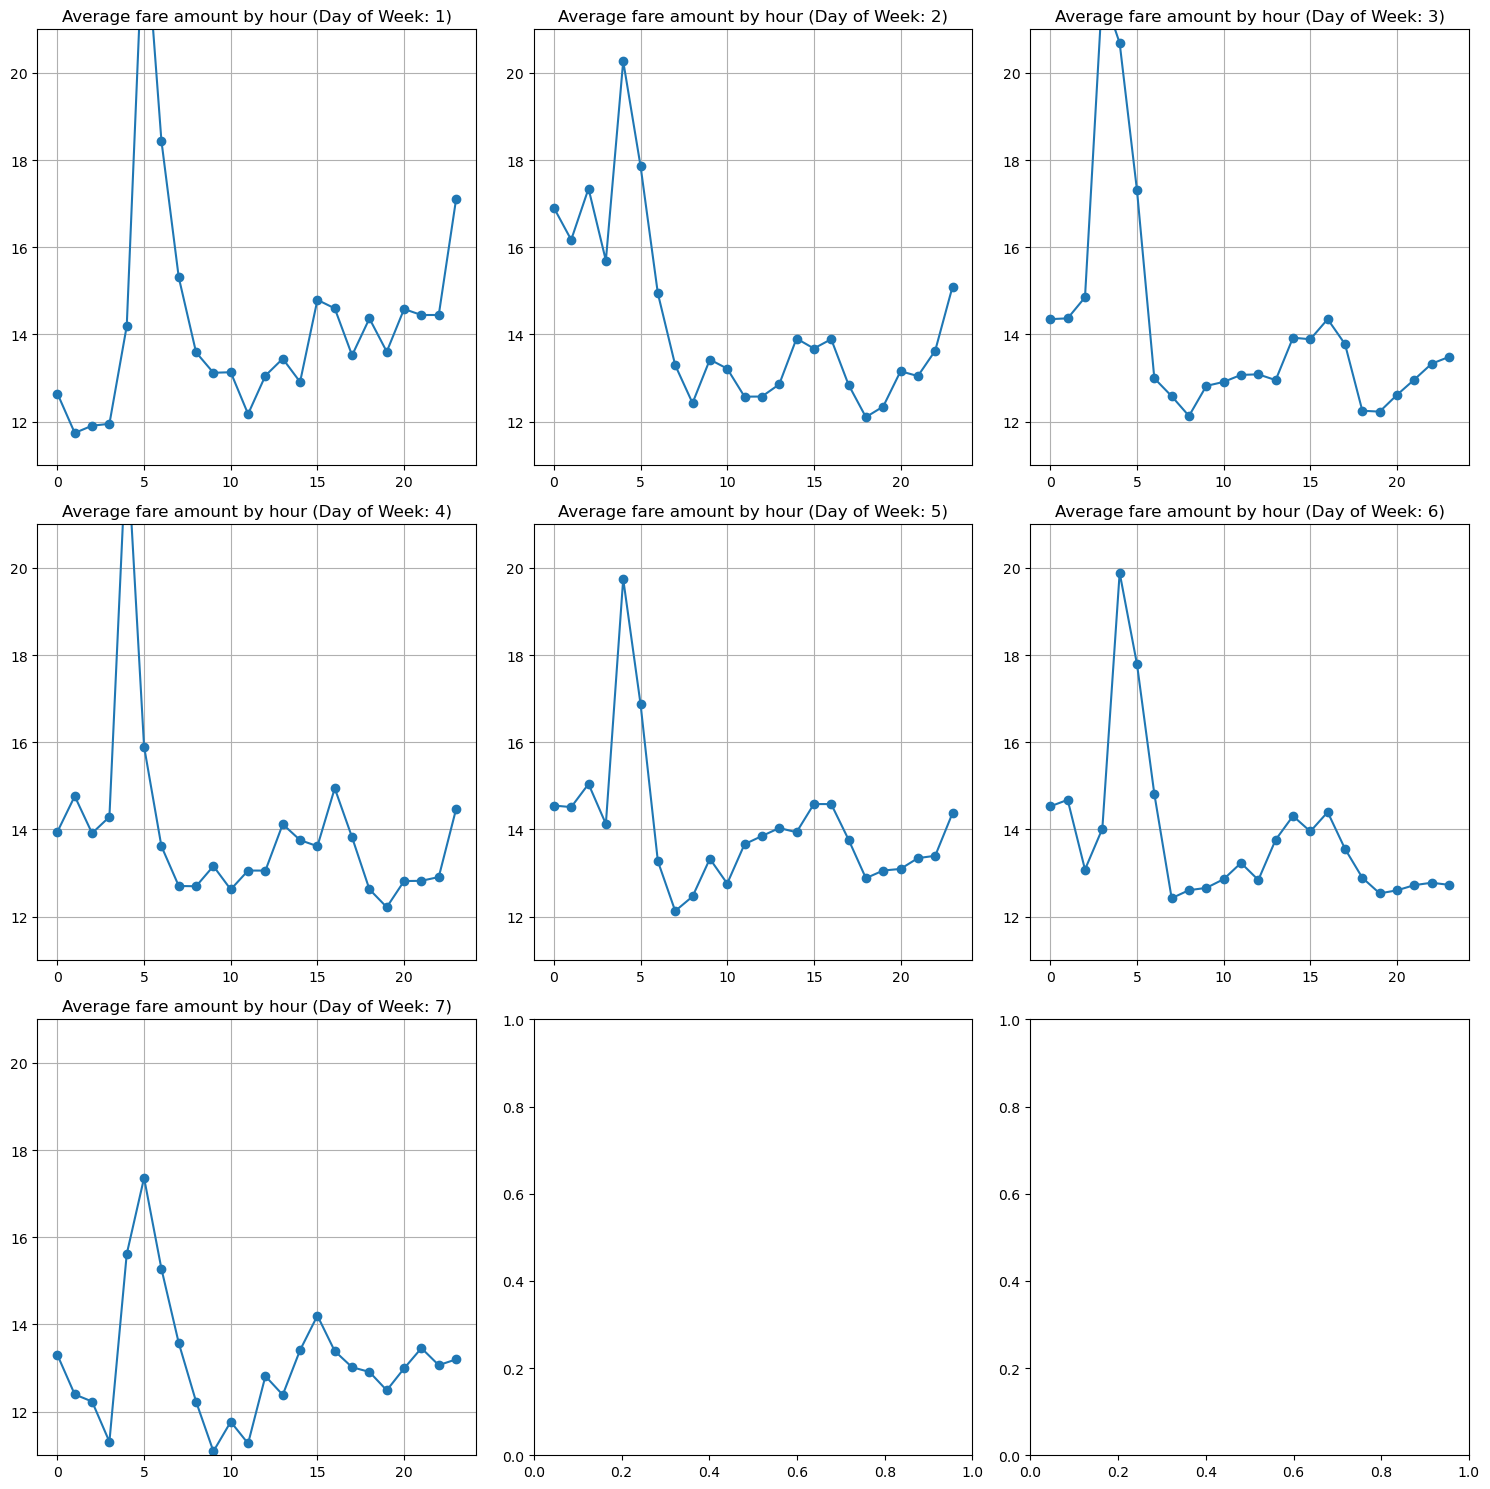

In [40]:
# Initialize a figure
fig, axs = plt.subplots(3, 3, figsize=(15,15))

# Flatten the axes array to iterate over it
axs = axs.flatten()

# Loop over each day of the week
for i in range(1, 8):
    # Filter data for a specific day of the week
    day_df = union_df.filter(F.col("pickup_dayofweek") == i)

    # Group by pickup_hour, calculate sums and counts
    day_grouped = day_df.groupBy("pickup_hour")\
                        .agg(F.sum("fare_amount").alias("total_fare"),
                             F.count("*").alias("pickup_count"))
    # Calculate averages
    day_grouped = day_grouped.withColumn("avg_fare", F.col("total_fare") / F.col("pickup_count"))

    # Convert to pandas DataFrame for plotting
    day_pd = day_grouped.toPandas()

    # Sort by pickup_hour for plotting
    day_pd = day_pd.sort_values("pickup_hour")

    # Plot average fare amount by hour
    axs[i-1].plot(day_pd["pickup_hour"], day_pd["avg_fare"], marker='o')
    axs[i-1].set_title('Average fare amount by hour (Day of Week: {})'.format(i))
    axs[i-1].set_ylim([10, 25])
    axs[i-1].grid(True)

plt.tight_layout()
plt.show()

**Insights: The line charts indicate that the patterns of average fare amount by hour are different among days of week. It's better to add *pickup_dayodweek* as categorical variable into the model for prediction.**

#### 3. By seasons: Average Fare Amount by Hour

In [ ]:
# Initialize a figure
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Flatten the axes array to iterate over it
axs = axs.flatten()

# Loop over each day of the week
for i in range(1,5):
    # Filter data for a specific day of the week
    season_df = union_df.filter(F.col("season") == i)

    # Group by pickup_hour, calculate sums and counts
    season_grouped = season_df.groupBy("pickup_hour")\
                        .agg(F.sum("fare_amount").alias("total_fare"),
                             F.count("*").alias("pickup_count"))
    # Calculate averages
    season_grouped = season_grouped.withColumn("avg_fare", F.col("total_fare") / F.col("pickup_count"))

    # Convert to pandas DataFrame for plotting
    season_pd = season_grouped.toPandas()

    # Sort by pickup_hour for plotting
    season_pd = season_pd.sort_values("pickup_hour")

    # Plot average fare amount by hour
    axs[i-1].plot(season_pd["pickup_hour"], season_pd["avg_fare"], marker='o')
    axs[i-1].set_title('Average fare amount by hour (Season: {})'.format(i))
    axs[i-1].set_ylim([11, 21])
    axs[i-1].grid(True)

plt.tight_layout()
plt.show()

**Insights: We can learn from the charts that the patterns of average fare amount by hour for four seasons are different. So that it's better to add *season* as a categorical variable and apply one-hot encoding in our model.**

#### 4. Trends by month form 2019 to 2021: Pickup Counts, Three Amounts and Trip Distance

In [34]:
# Aggregate data by year and month
yearmonth_df = union_df.groupBy("Datayear", "pickup_month") \
                     .agg(sum("fare_amount").alias("fare"),
                          sum("total_amount").alias("total"),
                          sum("tip_amount").alias("tip"),
                          sum("trip_distance").alias("distance"),
                          count("*").alias("pickup_count"))

# Calculate averages
yearmonth_df = yearmonth_df.withColumn("avg_fare", F.col("fare") / F.col("pickup_count"))
yearmonth_df = yearmonth_df.withColumn("avg_total", F.col("total") / F.col("pickup_count"))
yearmonth_df = yearmonth_df.withColumn("avg_tip", F.col("tip") / F.col("pickup_count"))
yearmonth_df = yearmonth_df.withColumn("avg_distance", F.col("distance") / F.col("pickup_count"))

In [35]:
yearmonth_plot = yearmonth_df.toPandas()

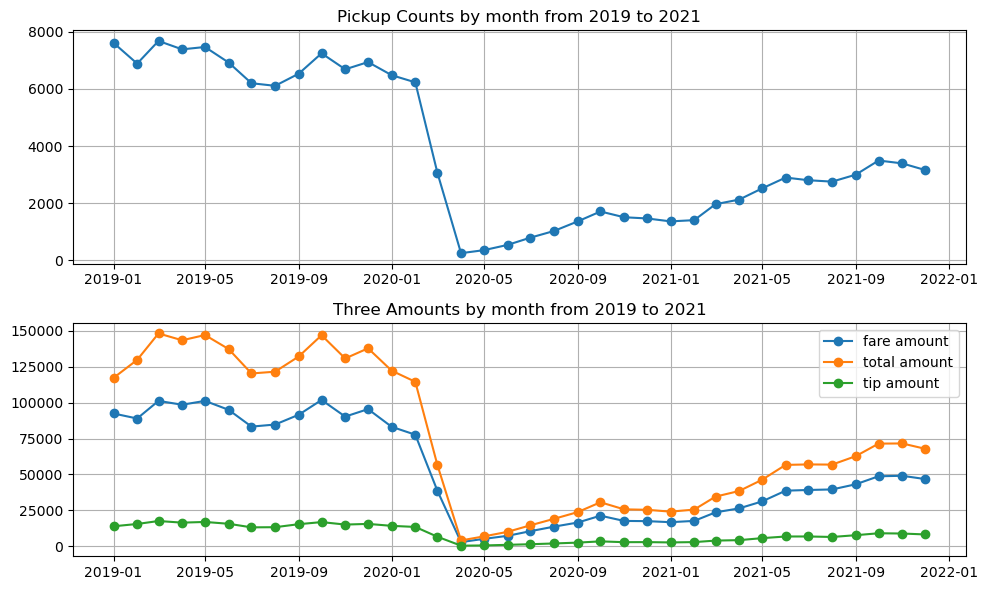

In [36]:
# Convert year and month to datetime and set as index
yearmonth_plot['date'] = pd.to_datetime(yearmonth_plot['Datayear'].astype(str) + '-' + yearmonth_plot['pickup_month'].astype(str) + '-01')
yearmonth_plot.set_index('date', inplace=True)

# Sort the DataFrame by date
yearmonth_plot = yearmonth_plot.sort_index()

# Filter data from 2019 to 2021
# yearmonth_plot = yearmonth_plot.loc['2019':'2021']

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot pickup count
plt.subplot(2, 1, 1)
plt.plot(yearmonth_plot.index, yearmonth_plot["pickup_count"], marker='o')
plt.title('Pickup Counts by month from 2019 to 2021')
plt.grid(True)

# Plot fare, total, and tip amounts
plt.subplot(2, 1, 2)
plt.plot(yearmonth_plot.index, yearmonth_plot["fare"], label='fare amount', marker='o')
plt.plot(yearmonth_plot.index, yearmonth_plot["total"], label='total amount', marker='o')
plt.plot(yearmonth_plot.index, yearmonth_plot["tip"], label='tip amount', marker='o')
plt.title('Three Amounts by month from 2019 to 2021')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

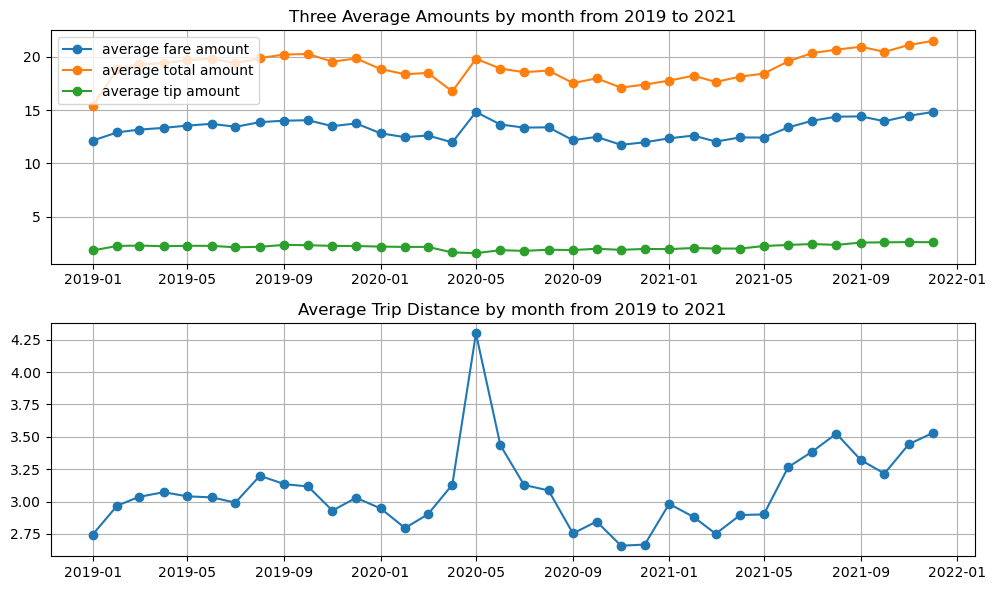

In [37]:
# Create a new figure
plt.figure(figsize=(10, 6))

# Plot average fare, total, and tip amounts
plt.subplot(2, 1, 1)
plt.plot(yearmonth_plot.index, yearmonth_plot["avg_fare"], label='average fare amount', marker='o')
plt.plot(yearmonth_plot.index, yearmonth_plot["avg_total"], label='average total amount', marker='o')
plt.plot(yearmonth_plot.index, yearmonth_plot["avg_tip"], label='average tip amount', marker='o')
plt.title('Three Average Amounts by month from 2019 to 2021')
plt.legend()
plt.grid(True)

# Plot average trip distance
plt.subplot(2, 1, 2)
plt.plot(yearmonth_plot.index, yearmonth_plot["avg_distance"], marker='o')
plt.title('Average Trip Distance by month from 2019 to 2021')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

**Insights: Covid-19 has had a big impact on the taxi market. The pickup counts and fare, tip and total amounts fell sharply at the beginning of 2020, and then rose slowly. However, by the end of 2021, they had not recovered to their 2019 levels. In addition, we can conclude from the charts that the amonts are mainly influenced by passenger flow, not by fare and tip reduction, because the average amounts do not show a plunge. The average fare and total amounts are affected by average trip distance. In May 2020, there is a sharp increase in average trip distance and also an increase in average fare and total amount.**

### Correlation heatmap

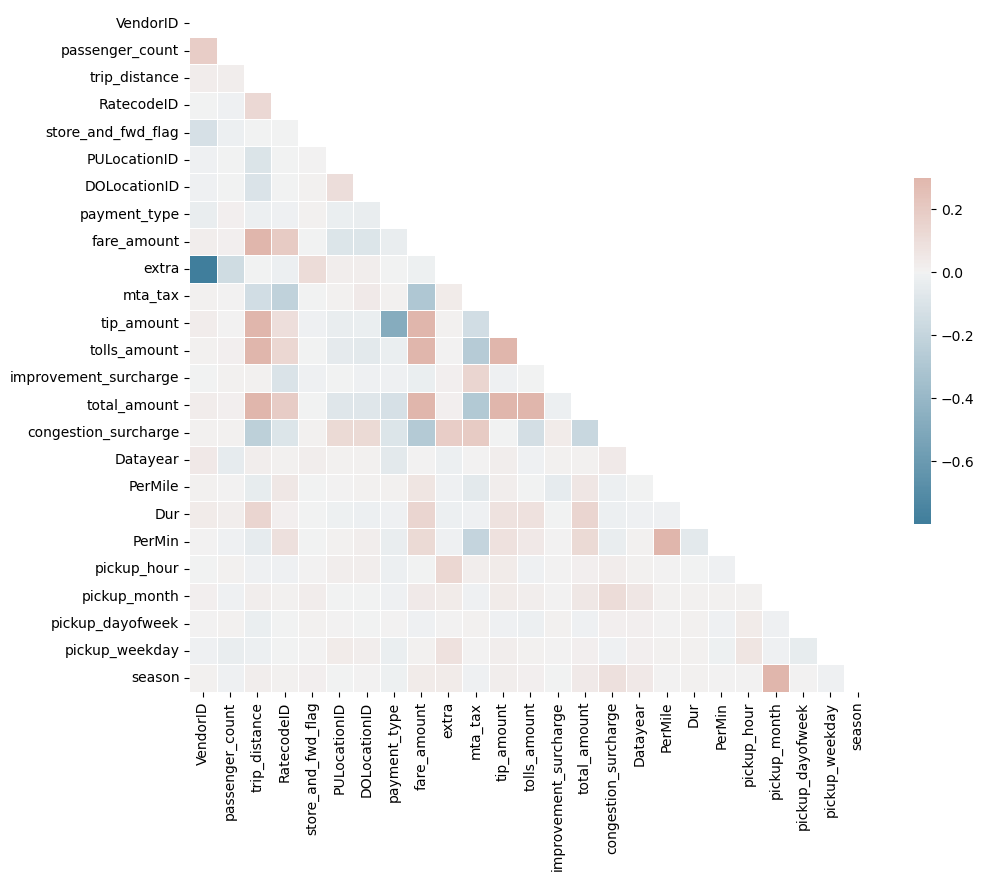

In [38]:
import seaborn as sns
import numpy as np

# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = union_df.drop('tpep_pickup_datetime','tpep_dropoff_datetime', 'parsed_pickup_datetime', 'parsed_dropoff_datetime',).toPandas()

# Compute correlation matrix
corr = pandas_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

**Insights: Most of the correlations are low, which means that most of the variables are not linearly related to each other.It's potentially good because low correlation means less redundancy in our data. In other words, each of the variables is providing unique information. This also implies that linear model may not be appropriate in subsequent steps.**